# Fairness Sandox Prototype

This rudimentary version of the framework will contain one dataset, one model, one bias mitigation algorithm, and a limited amount of validation metrics. Emphasis will be on modularity and abstraction so as to encourage more features in the future.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [ ]:
%pip install aif360
%pip install fairlearn
%pip install imbalanced-learn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
import aif360

# Data + EDA

### Dataset Class

In [10]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = []):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.df = pd.read_csv(path, sep = ';')

### Popular Datasets

In [16]:
# each dataset is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        print("Error! Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

In [17]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country','income']
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols, num_cols)

add_dataset(adult_income)

# TODO - add more datasets

In [18]:
cat = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel','freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_mat", path='Datasets/student-mat.csv', cat_cols=cat, num_cols=num))
add_dataset(Dataset("student_por", path='Datasets/student-por.csv', cat_cols=cat, num_cols=num))

In [19]:
# (potential) TODO: add functionality for missing data + 
#       encoding categorical features

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [20]:
# take a peek at the first few data points
df_por = datasets['student_por'].df
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


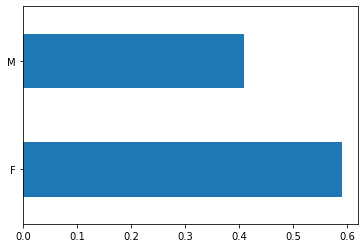

In [29]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
plot_counts(df_por, 'sex')

F
M


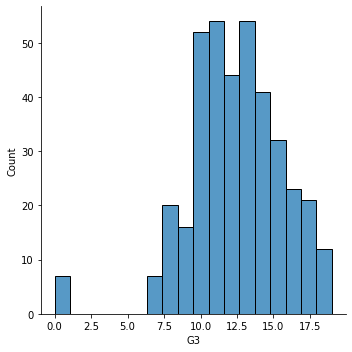

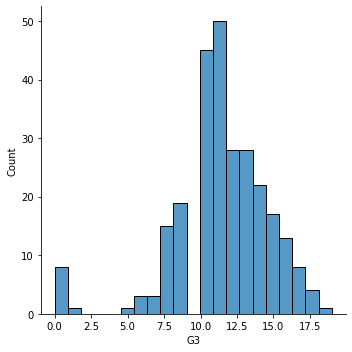

In [10]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
group_by_plot(df_por, 'sex', 'G3')

In [11]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Model

### Problem Formulation

In [27]:
def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
#generate_pnp(datasetMath)
threshold(df_por, threshold=14)
df_por['pass'].value_counts()

0    512
1    137
Name: pass, dtype: int64

We will now ask you to identify potential sensitive/protected attributes.

In [13]:
# for reference
print(datasets['student_por'].cat_cols)
print(datasets['student_por'].num_cols)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [52]:
sens_attrs = [df_por['sex'], df_por['address']]

### Model Selection + Training (TODO: modularize)

In [49]:
# format data
X = df_por.iloc[:, :-3].values
y = df_por.iloc[:, -1].values

# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols = get_cat_cols(datasets['student_por'])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [50]:
# Model Training

# modularize and add data struct of different ml techniques

y_true = df_por['pass']

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)

### Model Performance (TODO: modularize)

In [17]:
accuracy_score(y_pred, y_true)

0.9460708782742681

In [63]:
from fairlearn.metrics import *

gm = MetricFrame(accuracy_score, y_true, y_pred, sensitive_features = sens_attrs[0])
print("Overall Accuracy: ", gm.overall)
print("Group Accuracy: ", gm.by_group)

Overall Accuracy:  0.9460708782742681
Group Accuracy:  sex
F    0.937337
M    0.958647
Name: accuracy_score, dtype: object


In [64]:
gm = MetricFrame(accuracy_score, y_true, y_pred, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm.overall)
print("Group Accuracy : ", gm.by_group)

Overall Accuracy:  0.9460708782742681
Group Accuracy :  address
R    0.969543
U    0.935841
Name: accuracy_score, dtype: object


In [65]:
sr = MetricFrame(selection_rate, y_true, y_pred, sensitive_features = sens_attrs[0])
print("Overall Selection Rate: ", sr.overall)
print("Group Selection Rate : ", sr.by_group)

Overall Selection Rate:  0.20647149460708783
Group Selection Rate :  sex
F    0.234987
M    0.165414
Name: selection_rate, dtype: object


In [66]:
sr = MetricFrame(selection_rate, y_true, y_pred, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr.overall)
print("Group Selection Rate : ", sr.by_group)

Overall Selection Rate:  0.20647149460708783
Group Selection Rate :  address
R    0.137056
U    0.236726
Name: selection_rate, dtype: object


In [71]:
print("EOD", equalized_odds_difference(y_true=y_true, y_pred = y_pred, sensitive_features=sens_attrs[1]))
print("DPD", demographic_parity_difference(y_true=y_true, y_pred = y_pred, sensitive_features=sens_attrs[1]))

print("EOR", equalized_odds_ratio(y_true=y_true, y_pred = y_pred, sensitive_features=sens_attrs[1]))
print("DPR", demographic_parity_ratio(y_true=y_true, y_pred = y_pred, sensitive_features=sens_attrs[1]))

EOD 0.037328504770527196
DPD 0.0996698261533624
EOR 0.13895582329317271
DPR 0.5789648465297215


In [48]:
from fairlearn.metrics import *
metric_fns = {'selection_rate': selection_rate,
              'equalized_odds_difference': 
              equalized_odds_difference(y_true = y_true, y_pred = y_pred, sensitive_features=sens_attrs[1])}
eod = MetricFrame(metric_fns, y_true, y_pred, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", eod.overall)
print("Overall Selection Rate: ", eod.by_group)

NameError: name 'sens_attrs' is not defined

Thus, we can see that there is a **10% discrepancy** in the selection rate for Rural vs Urban students (with Urban students being preferred)

### Fairness Visualization (Keep this?)

In [21]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = df_por['sex'],
                   sensitive_feature_names = ['sex'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred})

/Users/manishn/cfpb-venv/lib/python3.7/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…

In [22]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = df_por['address'],
                   sensitive_feature_names = ['address'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…

# Bias Injection

### Class Visualization

In [28]:
#df_por.shape
df_por['pass'].value_counts()

0    512
1    137
Name: pass, dtype: int64

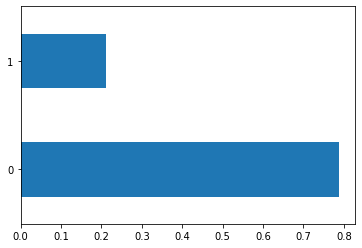

In [30]:
plot_counts(df_por, 'pass')

<AxesSubplot:>

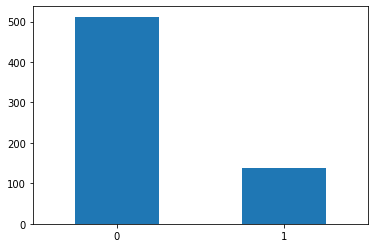

In [31]:
count = pd.value_counts(df_por['pass'], sort = True)
count.plot(kind = 'bar', rot = 0)

In [38]:
print('Og Shape {}'.format(Counter(y_true)))

Og Shape Counter({0: 512, 1: 137})


### Bias Selection

In [39]:
import imblearn

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

### Bias Injection

'0.8.0'

In [46]:
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X, y_true)

print('Og Shape {}'.format(Counter(y_true)))
print('Nm Shape {}'.format(Counter(y_nm)))

Og Shape Counter({0: 512, 1: 137})
Nm Shape Counter({0: 137, 1: 137})
[[1.0 0.0 1.0 ... 3 4 0]
 [1.0 0.0 1.0 ... 3 2 9]
 [1.0 0.0 1.0 ... 3 6 12]
 ...
 [0.0 1.0 1.0 ... 5 6 11]
 [0.0 1.0 0.0 ... 2 6 10]
 [0.0 1.0 0.0 ... 5 4 10]]
[[ 1.  0.  0. ...  5.  0. 15.]
 [ 1.  0.  1. ...  5.  2. 13.]
 [ 1.  0.  0. ...  3.  0. 13.]
 ...
 [ 0.  1.  0. ...  3.  4. 14.]
 [ 0.  1.  1. ...  4.  0. 14.]
 [ 0.  1.  1. ...  1.  4. 15.]]


### Post-Injection Visualization

In [ ]:
# TODO - add support for visualizing counts of minority and majority classes (before and after bias injection)

# Fairness Intervention

In [56]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0)
constraint = DemographicParity()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features = sens_attrs[1])
y_pred_mitigated = mitigator.predict(X)

# Evaluation

In [54]:
sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Selection Rate:  0.2172573189522342
Group Selection Rate :  address
R    0.208122
U    0.221239
Name: selection_rate, dtype: object


In [55]:
gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

Overall Accuracy:  0.9352850539291218
Group Accuracy :  address
R    0.949239
U    0.929204
Name: accuracy_score, dtype: object


In [26]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

print("Overall Accuracy: ", gm.overall)
print("Group Accuracy : ", gm.by_group)
print('\n')
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print('\n')

print("Overall Selection Rate: ", sr.overall)
print("Group Selection Rate : ", sr.by_group)
print('\n')
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.9460708782742681
Group Accuracy :  address
R    0.969543
U    0.935841
Name: accuracy_score, dtype: object


Overall Accuracy:  0.9352850539291218
Group Accuracy :  address
R    0.949239
U    0.929204
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.20647149460708783
Group Selection Rate :  address
R    0.137056
U    0.236726
Name: selection_rate, dtype: object


Overall Selection Rate:  0.2172573189522342
Group Selection Rate :  address
R    0.208122
U    0.221239
Name: selection_rate, dtype: object


Hence, we observe a decrease in overall and subgroup accuracy, but an **increase in disadvantaged subgroup selection rate**.

In [27]:
FairlearnDashboard(sensitive_features = sens_attrs[1],
                   sensitive_feature_names = ['address'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred, "mitigated model": y_pred_mitigated})

/Users/manishn/cfpb-venv/lib/python3.7/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…